# Detección oportuna de pacientes COVID mediante Rayos X

Integrantes:
- Sergio Renato Zegarra Villanueva (a20190028)
- Máximo Alejandro Guzmán Huamán (f1446907)

## Problema

El coronavirus, a pesar de haber pasado ya poco más de 3 años desde que terminó el confinamiento en el territorio nacional, puede representar aún una amenaza real y preligrosa. El riesgo puede aumentar vertiginosamente si se tiene una tardía detección del virus, tal y como aprendimos durante la pandemia. El líder en detección del SARS-CoV-2 es actualmente la prueba NAAT, hecha en laboratorio y cuyo resultado está disponible dentro de los 3 siguientes días de efectuada. La alternativa más popular, por otro lado, es la prueba de antígenos o "prueba rápida". El uso de ambas se ha normalizado a día de hoy; sin embargo, ambas tienen limitaciones. La prueba NAAT sólo puede ser utilizada si no se ha tenido una infección COVID dentro de los 90 días previos, y su gran sensibilidad compensa un tiempo de espera considerable; mientras que la prueba de antígenos es menos sensible que la prueba NAAT o incluso que la prueba molecular.

Por tal motivo, e inspirado en correlaciones estudiadas entre la infección del coronavirus y presencia de opacidades en rayos X del pecho, es que se deseó explorar un método de detección oportuna de esta infección con aplicación de Deep Learning. En concreto, se utilizó la arquitectura CheXNet con Transfer Learning para catalogar imágenes de rayos X filtradas en 4 categorías:

- **COVID-19**
- **Normal (Sin patología)**
- **Opacidad Pulmonar (Enfermedades no COVID)**
- **Neumonía Viral**

Esto es con la esperanza de asistir al personal médico en el diagnóstico médico por computadora.

## Dataset

Se utilizará el dataset "COVID-19 Radiography Database", ganador del premio a COVID-19 Dataset Award by Kaggle Community. Este dataset fue creado y actualizado por la Universidad de Qatar y la Universidad de Dhaka en Bangladesh.

 **Características del dataset:**
- **Cantidad de imágenes**: Más de 15,000 imágenes en total.
- **Resolución**: 299x299 píxeles (redimensionadas a 224x224 para el modelo).
- **Etiquetas disponibles**: COVID-19, Normal, Opacidad Pulmonar, Neumonía Viral.
- **Formato**: Imágenes en PNG con máscaras asociadas para resaltar regiones de interés.

Para más información, se puede descargar el dataset del siguient link:

https://www.kaggle.com/datasets/tawsifurrahman/covid19-radiography-database?resource=download

### Procesamiento del dataset

#### Importación de librerías

In [1]:
import os
import numpy as np
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
import cv2  # Para cargar imágenes y máscaras en OpenCV
from sklearn.model_selection import train_test_split

#### Ruta del dataset

In [5]:
DATASET_PATH = "./COVID_dataset"
CLASSES = ["COVID", "Normal", "Lung_Opacity", "Viral_Pneumonia"]

#### Cargar lista de imágenes y etiquetas con sus máscaras

##### Definición de función para filtrar las imágenes con sus máscaras

In [6]:
IMG_SIZE = 224 # Formato de input de la arquitectura

def apply_mask(image_path, mask_path):
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    
    # Redimensionar ambas imágenes
    image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))
    mask = cv2.resize(mask, (IMG_SIZE, IMG_SIZE))
    
    # Normalizar entre 0 y 1
    image = image / 255.0
    mask = mask / 255.0
    
    # Aplicar la máscara sobre la imagen
    image_filtered = image * mask
    
    # Convertir a RGB (3 canales) para CheXNet
    image_filtered = np.stack((image_filtered,) * 3, axis=-1)
    return image_filtered

##### Creación del DataFrame

Como queremos aplicarlo en diagnóstico médico, nos interesa también los casos en donde no es posible generar una máscara

In [7]:
# Crear una lista para almacenar las imágenes y etiquetas
data_with_masks = []
data_without_masks = []

for category in CLASSES:
    img_folder = os.path.join(DATASET_PATH, category, "images")
    mask_folder = os.path.join(DATASET_PATH, category, "masks")
    
    for img_name in os.listdir(img_folder):
        img_path = os.path.join(img_folder, img_name)
        mask_path = os.path.join(mask_folder, img_name)
        processed_img = apply_mask(img_path, mask_path)

        data_with_masks.append((processed_img, CLASSES.index(category)))
        
        # Cargar la imagen sin aplicar la máscara
        image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        image = cv2.resize(image, (IMG_SIZE, IMG_SIZE)) / 255.0
        image = np.stack((image,) * 3, axis=-1)
        data_without_masks.append((image, CLASSES.index(category)))

# Convertir a DataFrame
df_with_masks = pd.DataFrame(data_with_masks, columns=["image", "label"])
df_without_masks = pd.DataFrame(data_without_masks, columns=["image", "label"])


##### Ejemplo de Imagen

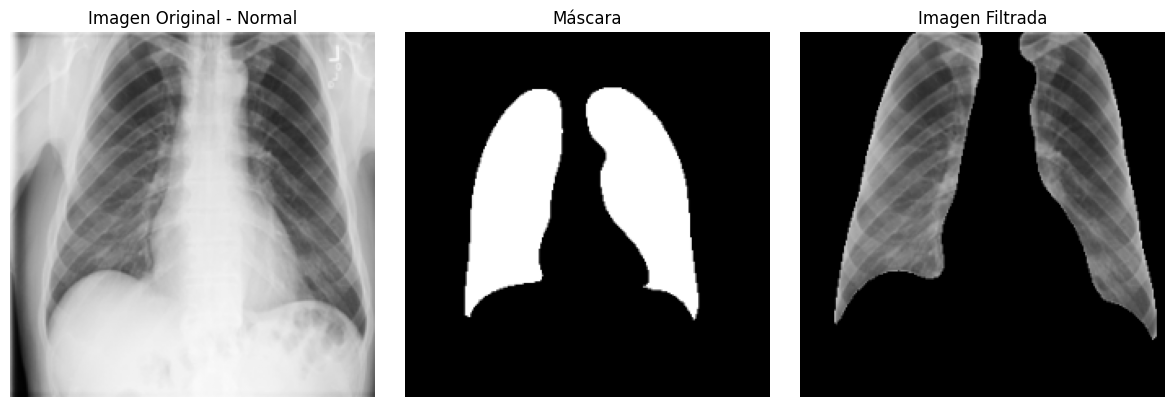

In [8]:
import random
import matplotlib.pyplot as plt

# Seleccionar una imagen aleatoria del dataset
sample_idx = random.randint(0, len(df_with_masks) - 1)

# Recuperar la imagen original sin máscara
original_image = df_without_masks.iloc[sample_idx]["image"]

# Recuperar la imagen filtrada con la máscara aplicada
filtered_image = df_with_masks.iloc[sample_idx]["image"]

# Obtener el nombre de la categoría
label_idx = df_with_masks.iloc[sample_idx]["label"]
label_name = CLASSES[label_idx]

# Recuperar la máscara directamente del directorio (usando el índice para obtener el path)
img_name = os.listdir(os.path.join(DATASET_PATH, CLASSES[label_idx], "images"))[sample_idx]
mask_path = os.path.join(DATASET_PATH, CLASSES[label_idx], "masks", img_name)
mask_image = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
mask_image = cv2.resize(mask_image, (IMG_SIZE, IMG_SIZE))

# Graficar los resultados
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

axes[0].imshow(original_image, cmap="gray")
axes[0].set_title(f"Imagen Original - {label_name}")
axes[0].axis("off")

axes[1].imshow(mask_image, cmap="gray")
axes[1].set_title("Máscara")
axes[1].axis("off")

axes[2].imshow(filtered_image, cmap="gray")
axes[2].set_title("Imagen Filtrada")
axes[2].axis("off")

plt.tight_layout()
plt.show()


##### División de entrenamiento (80%) y prueba (20%)

In [5]:
train_df, test_df = train_test_split(df_with_masks, test_size=0.2, stratify=df_with_masks["label"], random_state=42)

# Ahora extraemos los mismos índices para obtener el test set sin máscaras
test_indices = test_df.index  # Extraer los mismos índices
test_df_no_mask = df_without_masks.iloc[test_indices]  # Seleccionar imágenes sin máscara con los mismos índices

# Mostrar distribución de datos
print("Distribución del dataset con máscaras:")
print(train_df["label"].value_counts())
print(test_df["label"].value_counts())

print("\nDistribución del dataset sin máscaras:")
print(test_df_no_mask["label"].value_counts())  # Debe coincidir con test_df

Distribución del dataset con máscaras:
label
1    8154
2    4809
0    2893
3    1076
Name: count, dtype: int64
label
1    2038
2    1203
0     723
3     269
Name: count, dtype: int64

Distribución del dataset sin máscaras:
label
1    2038
2    1203
0     723
3     269
Name: count, dtype: int64


## Diseño de arquitectura y entrenamiento

Para la clasificación de imágenes de rayos X, utilizamos **CheXNet**, basado en la arquitectura **DenseNet121**. Este modelo ha sido entrenado previamente en imágenes de tórax y se adapta a nuestro problema con fine-tuning.

**Especificaciones del modelo:**
- **Arquitectura base**: DenseNet121
- **Entrada**: Imágenes de rayos X en escala de grises con tamaño 224x224.
- **Capa de salida**: 4 neuronas (una por cada clase) con activación softmax.
- **Optimización**: Algoritmo Adam con tasa de aprendizaje de 1e-4.
- **Pérdida**: Cross Entropy Loss para clasificación multiclase.

#### Importación de librerías

In [6]:
from torchvision import models, transforms
import torch.nn as nn
import torch.optim as optim

#### Clase COVIDDataset para consultar imágenes

In [7]:
class COVIDDataset(Dataset):
    def __init__(self, dataframe):
        self.dataframe = dataframe.reset_index(drop=True)
    
    def __len__(self):
        return len(self.dataframe)
    
    def __getitem__(self, idx):
        image = self.dataframe.iloc[idx]["image"]
        label = self.dataframe.iloc[idx]["label"]
        
        image_tensor = torch.tensor(image, dtype=torch.float32).permute(2, 0, 1)
        
        return image_tensor, torch.tensor(label, dtype=torch.long)

#### Creación de DataLoaders

In [8]:
BATCH_SIZE = 16
train_dataset = COVIDDataset(train_df)
test_dataset = COVIDDataset(test_df)
test_no_mask_dataset = COVIDDataset(test_df_no_mask)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_no_mask_loader = DataLoader(test_no_mask_dataset, batch_size=BATCH_SIZE, shuffle=False)

#### Preparación de Arquitectura CheXNet

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = models.densenet121(weights=models.DenseNet121_Weights.IMAGENET1K_V1).to(device)

# Modificar la última capa para 4 clases en lugar de 1000
model.classifier = nn.Linear(model.classifier.in_features, len(CLASSES)).to(device)

# Definir función de pérdida y optimizador
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

#### Entrenamiento

In [10]:
EPOCHS = 10
print("\nEntrenando el modelo con filtrado de máscaras...\n")
for epoch in range(EPOCHS):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f"Época {epoch+1}/{EPOCHS}, Pérdida: {running_loss/len(train_loader):.4f}")


Entrenando el modelo con filtrado de máscaras...

Época 1/10, Pérdida: 0.4306
Época 2/10, Pérdida: 0.2690
Época 3/10, Pérdida: 0.2101
Época 4/10, Pérdida: 0.1717
Época 5/10, Pérdida: 0.1313
Época 6/10, Pérdida: 0.1067
Época 7/10, Pérdida: 0.0901
Época 8/10, Pérdida: 0.0633
Época 9/10, Pérdida: 0.0606
Época 10/10, Pérdida: 0.0584


## Resultados y análisis

### Evaluación del modelo

In [ ]:
def evaluate_model(model, dataloader):
    model.eval()  # Poner el modelo en modo evaluación
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in dataloader:
            # Mover imágenes y etiquetas al mismo dispositivo que el modelo
            images, labels = images.to(device), labels.to(device)

            # Realizar predicción con el modelo
            outputs = model(images)
            preds = torch.argmax(outputs, dim=1)

            # Mover predicciones a CPU antes de convertir a numpy
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    return all_preds, all_labels

# Asegurar que el modelo está en el mismo dispositivo
model.to(device)

# Evaluar el modelo asegurando que todos los datos están en el mismo dispositivo
y_pred, y_true = evaluate_model(model, test_loader)
y_pred_without_masks, y_true_without_masks = evaluate_model(model, test_no_mask_loader)

# Verificación de dispositivos para evitar errores
print(f"Modelo en: {next(model.parameters()).device}")  # Verifica dónde está el modelo

Usando dispositivo: cuda
Modelo en: cuda:0


### Análisis

Para analizar el rendimiento en un entorno real, también evaluaremos el modelo con imágenes sin máscaras

#### Importación de librerías

In [13]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

#### Matrices de Confusión

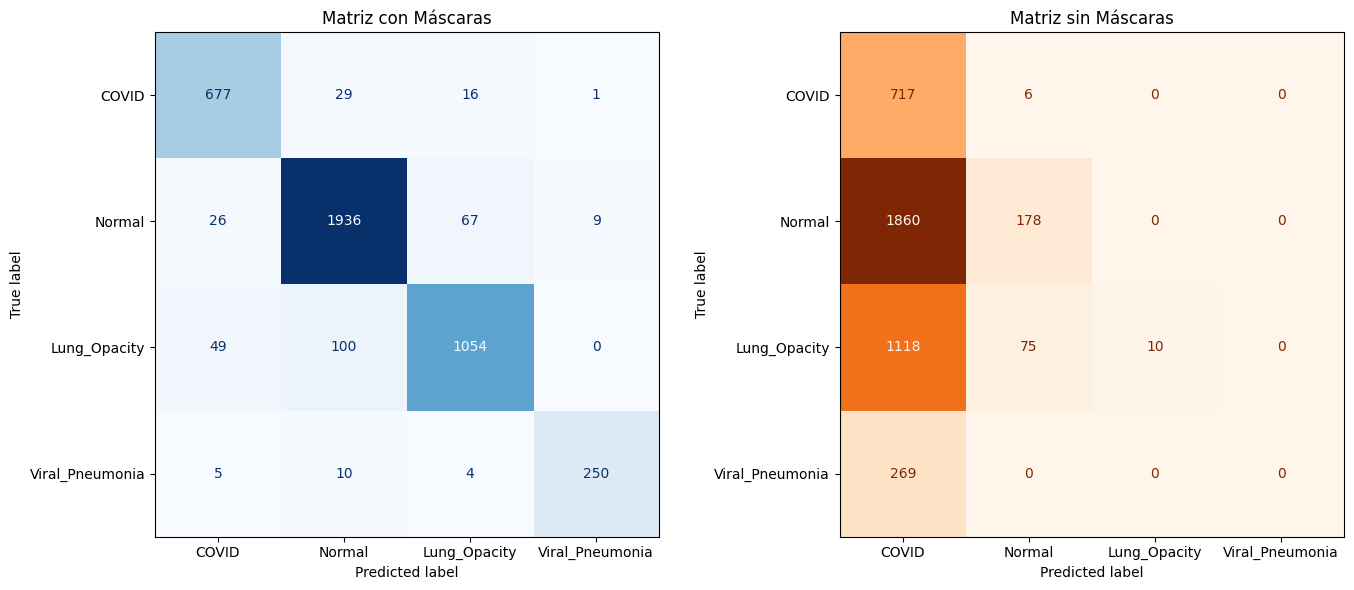

In [14]:
# Comparación de métricas con subplots mejorados
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

cm_with = confusion_matrix(y_true, y_pred)
cm_without = confusion_matrix(y_true_without_masks, y_pred_without_masks)

# Matriz de confusión con máscaras
disp_with = ConfusionMatrixDisplay(cm_with, display_labels=CLASSES)
disp_with.plot(ax=axes[0], cmap='Blues', colorbar=False)  # Desactivar colorbar
axes[0].set_title("Matriz con Máscaras")

# Matriz de confusión sin máscaras
disp_without = ConfusionMatrixDisplay(cm_without, display_labels=CLASSES)
disp_without.plot(ax=axes[1], cmap='Oranges', colorbar=False)  # También desactivar colorbar
axes[1].set_title("Matriz sin Máscaras")

# Ajustar el layout
plt.tight_layout()
plt.show()

#### Reporte de clasificación

In [15]:
from sklearn.metrics import classification_report

# Generar el reporte de clasificación
report_mask = classification_report(y_true, y_pred, target_names=CLASSES)
print("Reporte de Clasificación (c/ máscaras):\n", report_mask)

report_no_mask = classification_report(y_true_without_masks, y_pred_without_masks, target_names=CLASSES)
print("Reporte de Clasificación (s/ máscaras):\n", report_no_mask)

Reporte de Clasificación (c/ máscaras):
                  precision    recall  f1-score   support

          COVID       0.89      0.94      0.91       723
         Normal       0.93      0.95      0.94      2038
   Lung_Opacity       0.92      0.88      0.90      1203
Viral_Pneumonia       0.96      0.93      0.95       269

       accuracy                           0.93      4233
      macro avg       0.93      0.92      0.93      4233
   weighted avg       0.93      0.93      0.93      4233

Reporte de Clasificación (s/ máscaras):
                  precision    recall  f1-score   support

          COVID       0.18      0.99      0.31       723
         Normal       0.69      0.09      0.15      2038
   Lung_Opacity       1.00      0.01      0.02      1203
Viral_Pneumonia       0.00      0.00      0.00       269

       accuracy                           0.21      4233
      macro avg       0.47      0.27      0.12      4233
   weighted avg       0.65      0.21      0.13      4233



c:\Users\Maximo Guzman\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Maximo Guzman\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Maximo Guzman\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

#### Histograma de probabilidad promedio

In [16]:
# Obtener las probabilidades para las imágenes con máscara
model.eval()

probs_list_mask = []
with torch.no_grad():
    for images, _ in test_loader:
        images = images.to(device)
        outputs = model(images)
        probs = torch.nn.functional.softmax(outputs, dim=1)
        probs_list_mask.append(probs.cpu().numpy())

probs_with_masks = np.concatenate(probs_list_mask, axis=0)
max_probs_with_masks = np.max(probs_with_masks, axis=1)

# Probabilidades para dataset sin máscaras
probs_list_no_mask = []
with torch.no_grad():
    for images, _ in test_no_mask_loader:
        images = images.to(device)
        outputs = model(images)
        probs = torch.nn.functional.softmax(outputs, dim=1)
        probs_list_no_mask.append(probs.cpu().numpy())

probs_without_masks = np.concatenate(probs_list_no_mask, axis=0)
max_probs_without_masks = np.max(probs_without_masks, axis=1)

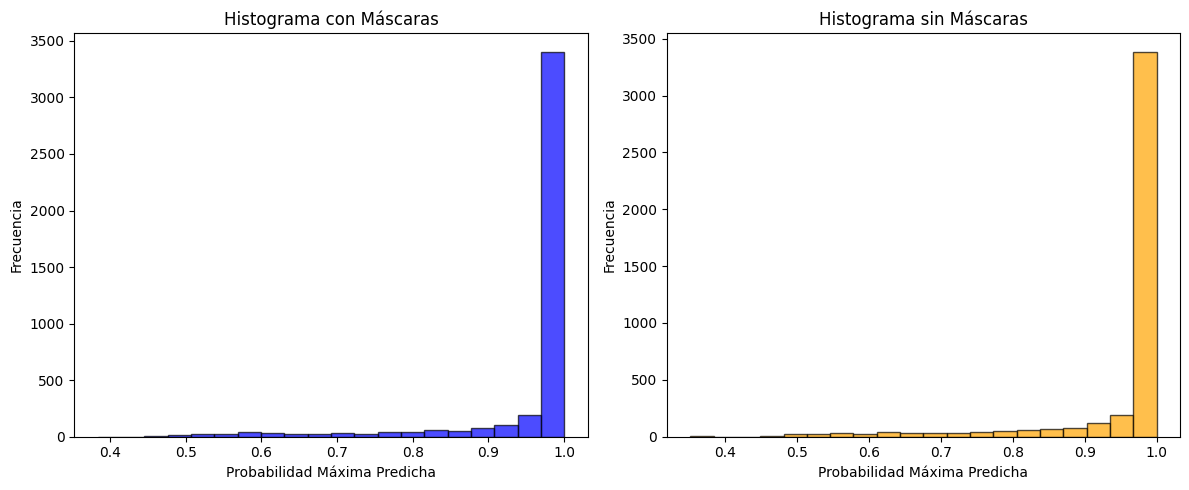

In [17]:
# Comparación de histogramas
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Histograma de probabilidades máximas con máscaras
axes[0].hist(max_probs_with_masks, bins=20, color='blue', alpha=0.7, edgecolor='black')
axes[0].set_title("Histograma con Máscaras")
axes[0].set_xlabel("Probabilidad Máxima Predicha")
axes[0].set_ylabel("Frecuencia")

# Histograma de probabilidades máximas sin máscaras
axes[1].hist(max_probs_without_masks, bins=20, color='orange', alpha=0.7, edgecolor='black')
axes[1].set_title("Histograma sin Máscaras")
axes[1].set_xlabel("Probabilidad Máxima Predicha")
axes[1].set_ylabel("Frecuencia")

plt.tight_layout()
plt.show()